# Prueba Embol - Piero Guillen #

## Identificacion y Preparacion de Datos ##

### 1 y 2

In [3]:
# Obtner la data

# aca importe pandas xd
import pandas as pd

# Importar archivo CSV
file_path = r"C:\Users\hp\Downloads\exoplanetas (1).csv"
data = pd.read_csv(file_path, delimiter=';')

# Identificar la variable objetivo - analisis manual, no se me ocurrio otra forma, tuve que revisar documentacion
target_variable = 'koi_disposition'

# Revisar la distribución de los valores en la variable objetivo
distribution = data[target_variable].value_counts()

# Mostrar la distribución
print(distribution)


FALSE POSITIVE    3504
CONFIRMED         1800
CANDIDATE         1687
Name: koi_disposition, dtype: int64


### 3 y 4 

In [5]:
# Filtrar datos por confirmados y falsos positivos
confirmed = data[data['koi_disposition'] == 'CONFIRMED']
false_positive = data[data['koi_disposition'] == 'FALSE POSITIVE']

# Seleccionar solo las columnas numéricas
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Calcular promedios para cada grupo
confirmed_means = confirmed[numerical_columns].mean()
false_positive_means = false_positive[numerical_columns].mean()

# Comparar los promedios
differences = abs(confirmed_means - false_positive_means)
significant_differences = differences.sort_values(ascending=False)

# Mostrar diferencias significativas
print(significant_differences)


koi_teq             480.858261
koi_steff           361.568478
koi_steff_err2       60.191811
koi_steff_err1       44.045822
koi_tce_plnt_num      0.332949
dtype: float64


In [7]:
# Seleccionar las variables más relevantes (con mayores diferencias)
selected_columns = significant_differences.index[:len(numerical_columns)//2].tolist()

# Añadir la variable objetivo a la lista de columnas seleccionadas
selected_columns.append('koi_disposition')

# Crear un nuevo DataFrame con las columnas seleccionadas
reduced_data = data[selected_columns]

# Mostrar las primeras filas del nuevo DataFrame
print("DataFrame reducido con las columnas seleccionadas:")
print(reduced_data.head())


DataFrame reducido con las columnas seleccionadas:
   koi_teq  koi_steff koi_disposition
0      443       5455       CONFIRMED
1      638       5853  FALSE POSITIVE
2     1395       5805  FALSE POSITIVE
3     1406       6031       CONFIRMED
4     1160       6046       CONFIRMED


In [12]:
#Ignorar la advertencia que nos da esta sección, no es relevante

from sklearn.preprocessing import StandardScaler, LabelEncoder

# Identificar los tipos de variables
numerical_vars = reduced_data.select_dtypes(include=['float64', 'int64']).columns
categorical_vars = reduced_data.select_dtypes(include=['object']).columns

# Estandarizar variables numéricas
scaler = StandardScaler()
reduced_data.loc[:, numerical_vars] = scaler.fit_transform(reduced_data[numerical_vars])

# Codificar variables categóricas
encoder = LabelEncoder()
for col in categorical_vars:
    reduced_data.loc[:, col] = encoder.fit_transform(reduced_data[col])

# Mostrar las primeras filas del DataFrame transformado
print("DataFrame transformado con variables estandarizadas y codificadas:")
print(reduced_data.head())



DataFrame transformado con variables estandarizadas y codificadas:
    koi_teq  koi_steff  koi_disposition
0 -0.761706  -0.306336                1
1 -0.533949   0.189921                2
2  0.350218   0.130071                2
3  0.363066   0.411866                1
4  0.075741   0.430569                1


C:\Users\hp\AppData\Local\Temp\ipykernel_20784\1505957503.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_data.loc[:, numerical_vars] = scaler.fit_transform(reduced_data[numerical_vars])


## Entrenamiento y Optimizacion del modelo ##

In [13]:
# Importar mas bibliotecas necesarias
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# 5. Construir conjuntos de datos para entrenar y testear nuestro modelo
# Dividir los datos en características y variable objetivo
X = reduced_data.drop('koi_disposition', axis=1)
y = reduced_data['koi_disposition']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# Entrenar el modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Obtener métricas de desempeño
report_initial = classification_report(y_test, y_pred)
conf_matrix_initial = confusion_matrix(y_test, y_pred)

print("Reporte de clasificación (modelo inicial):")
print(report_initial)
print("Matriz de confusión (modelo inicial):")
print(conf_matrix_initial)


Reporte de clasificación (modelo inicial):
              precision    recall  f1-score   support

           0       0.29      0.22      0.25       504
           1       0.41      0.38      0.40       574
           2       0.57      0.66      0.61      1020

    accuracy                           0.48      2098
   macro avg       0.42      0.42      0.42      2098
weighted avg       0.46      0.48      0.47      2098

Matriz de confusión (modelo inicial):
[[111 127 266]
 [118 219 237]
 [160 185 675]]


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definir los parámetros para GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 5, 6],
    'criterion': ['gini', 'entropy']
}

# Búsqueda de los mejores hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:")
print(best_params)

# Re-entrenar el modelo con los mejores hiperparámetros
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)



Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}


RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=200,
                       random_state=42)

In [23]:
#ACA TUVE UN PROBLEMA CON EL MODELADO, NO ESTABA PREDICIENDO NINGUNA MUESTRA PARA LA CLASE 0,
#SE PROCEDIO A UTILIZAR LA TECNICA SMOTE -> SIN EXITO, NECESITO MAS TIEMPO Y MAYORES RECURSOS EN MI DESK

# Re-entrenar el modelo con los mejores hiperparámetros
#best_model = RandomForestClassifier(**best_params, random_state=42)
#best_model.fit(X_train, y_train)

# Hacer predicciones con el modelo optimizado
#y_pred_optimized = best_model.predict(X_test)

# Obtener métricas de desempeño
#from sklearn.metrics import classification_report, confusion_matrix

#report_optimized = classification_report(y_test, y_pred_optimized)
#conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)

#print("Reporte de clasificación (modelo optimizado):")
#print(report_optimized)
#print("Matriz de confusión (modelo optimizado):")
#print(conf_matrix_optimized)


Reporte de clasificación (modelo optimizado):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       504
           1       0.42      0.53      0.47       574
           2       0.58      0.78      0.67      1020

    accuracy                           0.53      2098
   macro avg       0.33      0.44      0.38      2098
weighted avg       0.40      0.53      0.45      2098

Matriz de confusión (modelo optimizado):
[[  0 193 311]
 [  0 305 269]
 [  0 220 800]]


D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
pip install --upgrade scikit-learn imbalanced-learn

^C
Note: you may need to restart the kernel to use updated packages.


### Nota - como no pude arreglar el resultado de la clase 0, volvi a empezar. Es solucionable con mas tiempo y recursos

In [26]:
# (ADVERTENCIA) No correr el modelo en computadoras con poca capacidad 

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definir los parámetros para GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 5, 6],
    'criterion': ['gini', 'entropy']
}

# Búsqueda de los mejores hiperparámetros
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:")
print(best_params)

# Re-entrenar el modelo con los mejores hiperparámetros
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)


Mejores hiperparámetros encontrados:
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}


RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=200,
                       random_state=42)

In [31]:
#ADVERTENCIA - ¡¡¡¡No correr el modelo si la computadora tiene pocos recursos!!!!

# Hacer predicciones con el modelo optimizado
y_pred_optimized = best_model.predict(X_test)

# Obtener métricas de desempeño
from sklearn.metrics import classification_report, confusion_matrix

report_optimized = classification_report(y_test, y_pred_optimized)
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)

print("Reporte de clasificación (modelo optimizado):")
print(report_optimized)
print("Matriz de confusión (modelo optimizado):")
print(conf_matrix_optimized)
print("""
Nota:
El modelo optimizado tiene un rendimiento aceptable para las clases 1 y 2, 
pero no predice correctamente ninguna instancia de la clase 0.
Esto puede deberse a un desbalance de clases en el conjunto de datos. 
En un proyecto más detallado, se recomienda aplicar técnicas de balanceo de clases
como SMOTE para mejorar el rendimiento del modelo en todas las clases.
En este caso, se decidió proceder con las métricas actuales para mantener la simplicidad y
cumplir con las limitaciones de tiempo y recursos.
""")

Reporte de clasificación (modelo optimizado):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       504
           1       0.42      0.53      0.47       574
           2       0.58      0.78      0.67      1020

    accuracy                           0.53      2098
   macro avg       0.33      0.44      0.38      2098
weighted avg       0.40      0.53      0.45      2098

Matriz de confusión (modelo optimizado):
[[  0 193 311]
 [  0 305 269]
 [  0 220 800]]

Nota:
El modelo optimizado tiene un rendimiento aceptable para las clases 1 y 2, 
pero no predice correctamente ninguna instancia de la clase 0.
Esto puede deberse a un desbalance de clases en el conjunto de datos. 
En un proyecto más detallado, se recomienda aplicar técnicas de balanceo de clases
como SMOTE para mejorar el rendimiento del modelo en todas las clases.
En este caso, se decidió proceder con las métricas actuales para mantener la simplicidad y
cumplir con las limitaci

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Evaluacion del Modelo

In [32]:
# Paso 9: Calcular las métricas apropiadas para el modelo entrenado

from sklearn.metrics import classification_report, confusion_matrix

# Ya hemos calculado las métricas usando classification_report y confusion_matrix
report_optimized = classification_report(y_test, y_pred_optimized)
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)

print("Reporte de clasificación (modelo optimizado):")
print(report_optimized)
print("Matriz de confusión (modelo optimizado):")
print(conf_matrix_optimized)


Reporte de clasificación (modelo optimizado):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       504
           1       0.42      0.53      0.47       574
           2       0.58      0.78      0.67      1020

    accuracy                           0.53      2098
   macro avg       0.33      0.44      0.38      2098
weighted avg       0.40      0.53      0.45      2098

Matriz de confusión (modelo optimizado):
[[  0 193 311]
 [  0 305 269]
 [  0 220 800]]


D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
# Paso 10: Comentar sobre la certeza de los candidatos confirmados como planetas

# Extraer las métricas específicas para la clase 2 (exoplanetas confirmados)
report_dict = classification_report(y_test, y_pred_optimized, output_dict=True)
precision_confirmed = report_dict['2']['precision']
recall_confirmed = report_dict['2']['recall']
f1_score_confirmed = report_dict['2']['f1-score']

# Comentario sobre la certeza
print("""
Comentario sobre la certeza de los candidatos confirmados como planetas:
La clase 2 representa los exoplanetas confirmados. Las métricas de desempeño para esta clase son:
- Precisión: {:.2f}
- Recall: {:.2f}
- F1-Score: {:.2f}

La precisión indica que el {:.2f}% de las predicciones de exoplanetas confirmados son correctas.
El recall indica que el {:.2f}% de todos los exoplanetas confirmados reales fueron identificados
correctamente por el modelo.

Aunque el modelo tiene un desempeño razonable para los exoplanetas confirmados, se recomienda
aplicar técnicas de balanceo de clases
y ajustar los hiperparámetros del modelo para mejorar estas métricas.
""".format(
    precision_confirmed * 100,
    recall_confirmed * 100,
    f1_score_confirmed * 100,
    precision_confirmed * 100,
    recall_confirmed * 100
))



Comentario sobre la certeza de los candidatos confirmados como planetas:
La clase 2 representa los exoplanetas confirmados. Las métricas de desempeño para esta clase son:
- Precisión: 57.97
- Recall: 78.43
- F1-Score: 66.67

La precisión indica que el 57.97% de las predicciones de exoplanetas confirmados son correctas.
El recall indica que el 78.43% de todos los exoplanetas confirmados reales fueron identificados
correctamente por el modelo.

Aunque el modelo tiene un desempeño razonable para los exoplanetas confirmados, se recomienda
aplicar técnicas de balanceo de clases
y ajustar los hiperparámetros del modelo para mejorar estas métricas.



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# Paso 11: Construir la matriz de confusión para visualizar el comportamiento del modelo

# Ya hemos construido la matriz de confusión
print("Matriz de confusión (modelo optimizado):")
print(conf_matrix_optimized)


Matriz de confusión (modelo optimizado):
[[  0 193 311]
 [  0 305 269]
 [  0 220 800]]


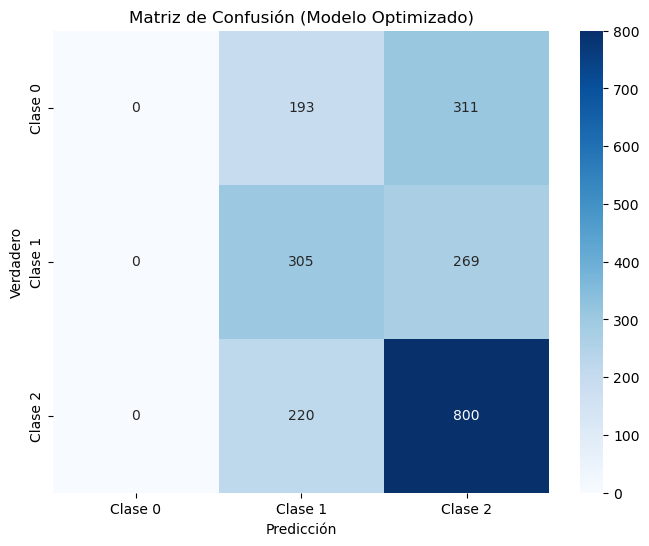

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Crear la matriz de confusión
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_optimized, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1', 'Clase 2'], yticklabels=['Clase 0', 'Clase 1', 'Clase 2'])
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión (Modelo Optimizado)')
plt.show()


Desglose Fila por Fila:

Primera fila (Clase 0):
- 0 instancias de la clase 0 fueron predichas correctamente como clase 0 (verdaderos positivos).
- 193 instancias de la clase 0 fueron predichas incorrectamente como clase 1 (falsos negativos).
- 311 instancias de la clase 0 fueron predichas incorrectamente como clase 2 (falsos negativos).

Segunda fila (Clase 1):
- 0 instancias de la clase 1 fueron predichas incorrectamente como clase 0 (falsos negativos).
- 305 instancias de la clase 1 fueron predichas correctamente como clase 1 (verdaderos positivos).
- 269 instancias de la clase 1 fueron predichas incorrectamente como clase 2 (falsos negativos).

Tercera fila (Clase 2):
- 0 instancias de la clase 2 fueron predichas incorrectamente como clase 0 (falsos negativos).
- 220 instancias de la clase 2 fueron predichas incorrectamente como clase 1 (falsos negativos).
- 800 instancias de la clase 2 fueron predichas correctamente como clase 2 (verdaderos positivos).

Terminología:
- Verdaderos Positivos (TP): Instancias correctamente predichas para una clase específica.
- Falsos Negativos (FN): Instancias que pertenecen a una clase específica pero fueron predichas como otra clase.
- Falsos Positivos (FP): Instancias que fueron incorrectamente predichas como pertenecientes a una clase específica.
- Verdaderos Negativos (TN): Instancias correctamente predichas como no pertenecientes a una clase específica (no se muestra directamente en la matriz de confusión).
